# Konvoluční sítě pro klasifikaci

Úkolem cvičení je upravit tento notebook a dosáhnout co nejlepšího možného validačního skóre na datasetu CIFAR-10. Viz nápovědu a možné směry úprav v komentářích u jednotlivých buněk. Klasifikaci obrázků pomocí konvolučních sítí v PyTorch popisuje notebook [pytorch-convnets](lectures/pytorch-convnets.ipynb). 

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import torchvision.models as models
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import transforms as At 

import ans

## Načtení CIFAR10

In [43]:
# zlepsi predzpracovani a jine augmentace skore?
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=[-30,30],expand=False),
    transforms.RandomHorizontalFlip(p=0.65),
    transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.4914, 0.4822, 0.4465], std = [0.247, 0.243, 0.261]) 
])
#(0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)
basic_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.4914, 0.4822, 0.4465], std = [0.247, 0.243, 0.261])
])

a_train_transform = A.Compose([
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
        A.Blur(blur_limit=3),
        A.OpticalDistortion(),
        A.Normalize(),
        At.ToTensor()
])

In [44]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=basic_transform)
train_aug_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=train_transform)
train_a_aug_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=a_train_transform)
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
           )

In [45]:
# augmentaci lze provadet i v testovacim rezimu
valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.4914, 0.4822, 0.4465], std = [0.247, 0.243, 0.261])
])


In [46]:
valid_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=valid_transform)
valid_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
           )

In [47]:
BATCH_SIZE = 64
concat_train_dataset = torch.utils.data.ConcatDataset([train_dataset,train_aug_dataset,train_dataset])
# pomuze jina batch_size?
train_loader = torch.utils.data.DataLoader(concat_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [48]:
# it is balanced
if False:
    counts = {}
    g = tqdm.auto.tqdm(valid_loader, desc="Train data")

    for inputs, targets in g:
        for target in targets:

            if int(target) in counts:
                counts[int(target)] +=1
            else:
                counts[int(target)] = 1
                print(inputs)
    print(counts)
    

## Kritérium

In [49]:
class MyHingeLoss(torch.nn.Module):

    def __init__(self):
        super(MyHingeLoss, self).__init__()

    def forward(self, output, target):

        hinge_loss = 1 - torch.mul(output, target)
        hinge_loss[hinge_loss < 0] = 0
        return hinge_loss

In [50]:
# muze zlepsit skore napr. SVM?
crit = nn.CrossEntropyLoss() # .748
crit

CrossEntropyLoss()

## Definice konvoluční sítě

Síť definujte následující třídou `Convnet`. Architekturu síťě můžete navrhnout sami ručně, nebo lze použít jeden z existujících modelů, např. z katalogu `torchvision.models`. Není povoleno použít předtrénovaný model, tj. s vahami již natrénovanými na jiných datasetech, např. ImageNet.

In [51]:
class Convnet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 96, 6,stride=4, padding=1, bias=False)
        self.conv2 = nn.Conv2d(96, 256, 5, padding=1, bias=False)
        self.conv3 = nn.Conv2d(256, 384, 3, padding=1, bias=False)
        self.conv4 = nn.Conv2d(384, 384, 3, padding=1, bias=False)
        self.conv5 = nn.Conv2d(384, 256, 2, padding=1, bias=False)
        self.conv5_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.fc3 = nn.Linear(1024, 10)
    
    def forward(self, x):
        # prvni konv. vrstva
        x = self.conv1(x)
        x = F.leaky_relu(x)
        x = self.conv2(x)
        x = F.leaky_relu(x)
        x = F.max_pool2d(x, 2)
        
        # druha konv. vrstva
        x = self.conv3(x)
        x = F.leaky_relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.conv4(x)
        x = F.leaky_relu(x)
        x = self.conv5_drop(self.conv5(x))
        x = F.leaky_relu(x)
        x = F.max_pool2d(x, 2)
        
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        
        return x

## Trénování a validace

In [52]:
# pokud vytvorime novou sit, vyresetujeme i statistiky
model = Convnet()
model = models.resnet18(pretrained=False)
stats = ans.Stats()
device = 'cuda'
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [53]:
device = 'cuda'
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [54]:
for name, par in model.named_parameters():
    print(name, par.dtype, par.shape, par.numel())

conv1.weight torch.float32 torch.Size([64, 3, 7, 7]) 9408
bn1.weight torch.float32 torch.Size([64]) 64
bn1.bias torch.float32 torch.Size([64]) 64
layer1.0.conv1.weight torch.float32 torch.Size([64, 64, 3, 3]) 36864
layer1.0.bn1.weight torch.float32 torch.Size([64]) 64
layer1.0.bn1.bias torch.float32 torch.Size([64]) 64
layer1.0.conv2.weight torch.float32 torch.Size([64, 64, 3, 3]) 36864
layer1.0.bn2.weight torch.float32 torch.Size([64]) 64
layer1.0.bn2.bias torch.float32 torch.Size([64]) 64
layer1.1.conv1.weight torch.float32 torch.Size([64, 64, 3, 3]) 36864
layer1.1.bn1.weight torch.float32 torch.Size([64]) 64
layer1.1.bn1.bias torch.float32 torch.Size([64]) 64
layer1.1.conv2.weight torch.float32 torch.Size([64, 64, 3, 3]) 36864
layer1.1.bn2.weight torch.float32 torch.Size([64]) 64
layer1.1.bn2.bias torch.float32 torch.Size([64]) 64
layer2.0.conv1.weight torch.float32 torch.Size([128, 64, 3, 3]) 73728
layer2.0.bn1.weight torch.float32 torch.Size([128]) 128
layer2.0.bn1.bias torch.floa

In [55]:
# s novou siti musime obnovit i seznam parametru pro optimizer
# lepsich vysledku obvykle dosahuje SGD s momentum

#optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.8)
default_lr = optimizer.param_groups[0]['lr'];
print(default_lr)
total_epochs = 0;
optimizer

0.01


SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.8
    nesterov: False
    weight_decay: 0
)

In [56]:
# nasledujici kod libovolne upravujte

def train_step(model, batch, crit, optimizer, stats):
    # prepnout model do trenovaciho rezimu (tyka se vrstev jako Dropout nebo BatchNorm2d)
    model.train()
    
    # zajistit, aby model i data byla na stejnem zarizeni (cpu vs gpu)
    device = next(model.parameters()).device
    inputs, targets = batch
    inputs, targets = inputs.to(device), targets.to(device)
    
    # dopredny pruchod
    scores = model(inputs)

    # loss
    loss = crit(scores, targets)

    # pred zpetnym pruchodem vycistit prip. existujici gradienty z minulych iteraci
    optimizer.zero_grad()

    # zpetny pruchod, gradienty se ulozi primo do parametru modelu do atributu `grad`
    loss.backward()

    # update parametru na zaklade atributu `grad`
    optimizer.step()

    # vyhodnotime presnost
    _, pred = scores.max(dim=1)
    acc = torch.sum(pred == targets).float() / targets.shape[0]
    
    # update aktualnich statistik
    stats.append_batch_stats('train', loss=float(loss), acc=float(acc))

In [57]:
# jaky vliv ma pocet epoch?
# zkuste postupne menit learning rate (optimizer.param_groups[0]['lr'] = ...)
# nebo pomoci scheduleru (https://pytorch.org/docs/master/optim.html#how-to-adjust-learning-rate)
EPOCHS = 20
lr_steps = [10,15]
optimizer.param_groups[0]['lr'] = default_lr
for ep in range(EPOCHS):
    stats.new_epoch()
    total_epochs += 1
    if ep in lr_steps:
        optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr']/10
        print("New lr: ",optimizer.param_groups[0]['lr'])
    # trenovaci faze
    pb = tqdm.auto.tqdm(train_loader, desc='epoch {:02d} train'.format(ep+1))
    for inputs, targets in pb:
        train_step(model, (inputs, targets), crit, optimizer, stats)
        
        pb.set_postfix(
            loss='{:.3f}'.format(stats.ravg('train', 'loss')),
            acc='{:.3f}'.format(stats.ravg('train', 'acc'))
        )
    
    # validacni faze
    ans.validate(model, crit, valid_loader, stats)


New lr:  0.001



New lr:  0.0001


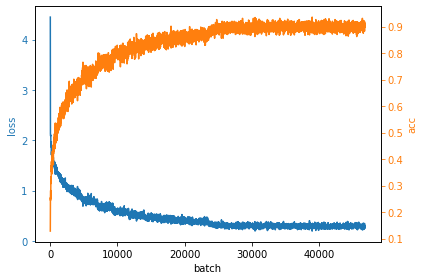

In [63]:
stats.plot_by_batch(block_len=10)

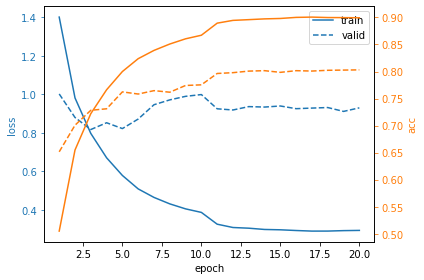

In [64]:
stats.plot_by_epoch()

In [65]:
stats.best_results()

Epoch 20,loss,acc
train,0.292887,0.899346
valid,0.929734,0.803045


## Predikce na testovacím obrázku

In [61]:
rgb_test = cv2.imread('./data/happy-green-frog.jpg')[..., ::-1]
rgb_test.dtype, rgb_test.shape, rgb_test.min(), rgb_test.max()

(dtype('uint8'), (500, 500, 3), 0, 252)

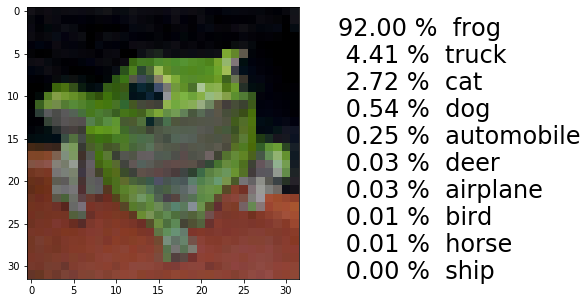

In [62]:
ans.predict_and_show(cv2.resize(rgb_test, (32, 32)), model, valid_transform, classes=train_dataset.classes)